In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


2022-12-12 22:39:38.633381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:39:41.294844: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 22:39:44.242567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-12-12 22:39:44.

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.11.0
keras version 2.11.0
Eager Execution Enabled: True


2022-12-12 22:39:50.041084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:39:52.515412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:2f:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Reading the data

In [4]:
%%capture
# !unzip "./all_data/sep_1/data.zip" -d "./temp_data/sep_1/"

In [5]:
# Getting the folder names 
folder_names_1 = glob.glob("./temp_data/sep_1/data/*")
folder_names_2 = glob.glob("./temp_data/sep_0.7/data/*")
folder_names = folder_names_1 + folder_names_2
# folder_names = folder_names_1
# folder_names = folder_names_2

In [6]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [7]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [8]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

In [9]:
# Targets for sep_1
target = np.array([[-0.314,1.661,0.45],[0,1.661,0.45],[0.314,1.661,0.45],[-0.314,1.347,0.45],[0,1.347,0.45],[0.314,1.347,0.45],[-0.314,1.033,0.45],[0,1.033,0.45],[0.314,1.033,0.45]])

## Adding Features

In [10]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [11]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

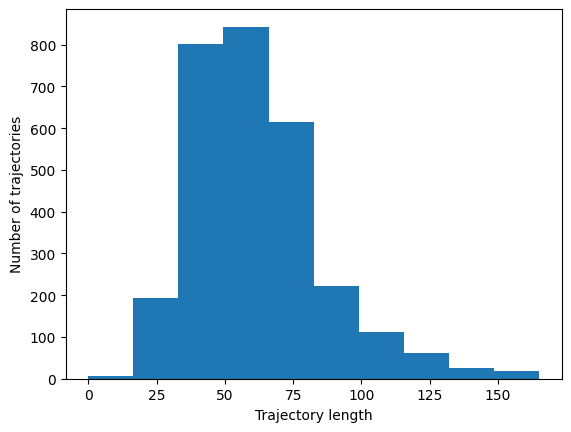

In [12]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories");

In [13]:
# Getting the mean trajectory lengths
np.mean(lengths)

61.28389099689548

In [15]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 5.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [16]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 5.)

(array([], dtype=int64),)

In [17]:
# For target prediction
# labels_3d = [target[i] for i in labels]
data_3d = []
target_3d = []
for i in cent_data:
    data_3d.append(i.iloc[:-1,:])
    target_3d.append(i.iloc[1:,:])

## Splitting the data into training and testing

In [18]:
# Train test split
# x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2, random_state = 7)
x_train_, x_test_, y_train_, y_test_ = train_test_split(data_3d, target_3d, test_size=0.2, random_state = 7)
# _, _, y_train_labels, y_test_labels = train_test_split(data_3d, target_3d, test_size=0.2, random_state = 7)

## Data Augmentation

In [21]:
x_train_aug = []
for idx,i in enumerate(x_train_):
    ch = np.random.choice([0,1],p = [0.3,0.7])

    flag = 0 

    if ch == 0: # Perform data augmentation

        trim = len(i)//2

        if trim >= 5: # Trim if the lengths are greater than 5

            aug = i.head(trim)

        else: # If lengths are not greater than 1, don't trim

            aug = i
    else:
        aug = i


    x_train_aug.append(aug)


In [22]:
# Printing out the lengths after and before augmentation
len(x_train_aug), len(x_train_)

(2315, 2315)

## Data Formatting

In [23]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
# y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
# y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [24]:
# Sequence length is based on data analysis
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train_, padding='post', dtype='float', maxlen=200, value = -10))
y_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(y_train_, padding='post', dtype='float', maxlen=200))
# y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test_, padding='post', dtype='float', maxlen=200, value = -10))
y_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(y_test_, padding='post', dtype='float', maxlen=200))
# y_test = tf.convert_to_tensor(y_test)

In [204]:
# One hot encoding the data for training - not required for label_3d
# y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
# y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Models

### Creating the RNN model

In [152]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(9, activation='softmax')
output = dense_2(h_2)

model_RNN = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the RNN model - labels_3d

In [52]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(3, activation='linear')
output = dense_2(h_2)

model_RNN_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_3d.compile(loss='mse', metrics = ['mse'], optimizer=Adam(1e-2))

### Creating the LSTM model

In [53]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h)

model_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the LSTM model - labels_3d

In [205]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

masking = tf.keras.layers.Masking(mask_value=-10.)
masked_op = masking(seq_input)

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(masked_op)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(3, activation='linear')
output = dense(h)

model_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM_3d.compile(loss='mse', metrics = ['mse'],optimizer=Adam(1e-2))

### Creating the LSTM+RNN model

In [122]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h_2)

model_RNN_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

AttributeError: 'list' object has no attribute 'shape'

### Creating the LSTM+RNN model - labels_3d

In [31]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(3, activation='linear')
output = dense(h_2)

model_RNN_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM_3d.compile(loss='mse', metrics = ['mse'], optimizer=Adam(1e-2))

In [206]:
model_LSTM_3d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 masking (Masking)           (None, 200, 3)            0         
                                                                 
 dense (Dense)               (None, 200, 15)           60        
                                                                 
 lstm (LSTM)                 (None, 200, 15)           1860      
                                                                 
 dense_1 (Dense)             (None, 200, 3)            48        
                                                                 
Total params: 1,968
Trainable params: 1,968
Non-trainable params: 0
_________________________________________________________________


In [207]:
# callbacks = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=100,
#     restore_best_weights = True
# )

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=100,
    restore_best_weights = True
)

In [208]:
history = model_LSTM_3d.fit(x_train,y_train, epochs=1000, batch_size=16, validation_split=0.2,callbacks = [callbacks])

Epoch 1/1000
116/116 [==============================] - 7s 28ms/step - loss: 0.0341 - mse: 0.0359 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/1000
116/116 [==============================] - 2s 16ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 8.0514e-04 - val_mse: 8.0403e-04
Epoch 3/1000
116/116 [==============================] - 2s 16ms/step - loss: 5.2689e-04 - mse: 5.2641e-04 - val_loss: 3.6311e-04 - val_mse: 3.6303e-04
Epoch 4/1000
116/116 [==============================] - 2s 16ms/step - loss: 2.7428e-04 - mse: 2.7298e-04 - val_loss: 2.8387e-04 - val_mse: 2.8427e-04
Epoch 5/1000
116/116 [==============================] - 2s 15ms/step - loss: 2.0808e-04 - mse: 2.0757e-04 - val_loss: 1.5754e-04 - val_mse: 1.5770e-04
Epoch 6/1000
116/116 [==============================] - 2s 16ms/step - loss: 1.5376e-04 - mse: 1.5374e-04 - val_loss: 1.2635e-04 - val_mse: 1.2661e-04
Epoch 7/1000
116/116 [==============================] - 2s 15ms/step - loss: 1.2589e-04 - mse: 1.2491e-04 - val_loss: 

Epoch 109/1000
116/116 [==============================] - 2s 16ms/step - loss: 2.7781e-05 - mse: 2.7678e-05 - val_loss: 3.5680e-05 - val_mse: 3.5909e-05
Epoch 110/1000
116/116 [==============================] - 2s 16ms/step - loss: 2.2921e-05 - mse: 2.2974e-05 - val_loss: 1.1516e-05 - val_mse: 1.1527e-05
Epoch 111/1000
116/116 [==============================] - 2s 15ms/step - loss: 1.2227e-05 - mse: 1.2363e-05 - val_loss: 3.3668e-05 - val_mse: 3.3668e-05
Epoch 112/1000
116/116 [==============================] - 2s 15ms/step - loss: 2.1747e-05 - mse: 2.1996e-05 - val_loss: 1.6462e-05 - val_mse: 1.6479e-05
Epoch 113/1000
116/116 [==============================] - 2s 15ms/step - loss: 1.2198e-05 - mse: 1.2253e-05 - val_loss: 1.6537e-05 - val_mse: 1.6555e-05
Epoch 114/1000
116/116 [==============================] - 2s 15ms/step - loss: 2.4201e-05 - mse: 2.3998e-05 - val_loss: 2.7113e-05 - val_mse: 2.7152e-05
Epoch 115/1000
116/116 [==============================] - 2s 16ms/step - loss: 1.3

116/116 [==============================] - 2s 15ms/step - loss: 1.6181e-05 - mse: 1.6174e-05 - val_loss: 7.0444e-05 - val_mse: 7.0429e-05
Epoch 216/1000
116/116 [==============================] - 2s 16ms/step - loss: 3.7042e-05 - mse: 3.7698e-05 - val_loss: 9.7615e-06 - val_mse: 9.7529e-06
Epoch 217/1000
116/116 [==============================] - 2s 15ms/step - loss: 7.8338e-06 - mse: 7.8805e-06 - val_loss: 9.3755e-06 - val_mse: 9.3636e-06
Epoch 218/1000
116/116 [==============================] - 2s 16ms/step - loss: 8.2613e-06 - mse: 8.2438e-06 - val_loss: 1.0883e-05 - val_mse: 1.0857e-05
Epoch 219/1000
116/116 [==============================] - 2s 16ms/step - loss: 9.5517e-06 - mse: 9.6236e-06 - val_loss: 1.2357e-05 - val_mse: 1.2380e-05
Epoch 220/1000
116/116 [==============================] - 2s 15ms/step - loss: 1.1802e-05 - mse: 1.1844e-05 - val_loss: 1.2272e-05 - val_mse: 1.2267e-05
Epoch 221/1000
116/116 [==============================] - 2s 15ms/step - loss: 1.2183e-05 - mse: 

116/116 [==============================] - 2s 18ms/step - loss: 9.4065e-06 - mse: 9.3223e-06 - val_loss: 9.4173e-06 - val_mse: 9.4115e-06
Epoch 322/1000
116/116 [==============================] - 2s 17ms/step - loss: 9.0462e-06 - mse: 8.9661e-06 - val_loss: 2.1495e-05 - val_mse: 2.1657e-05
Epoch 323/1000
116/116 [==============================] - 2s 17ms/step - loss: 1.2308e-05 - mse: 1.2427e-05 - val_loss: 9.1842e-06 - val_mse: 9.1755e-06
Epoch 324/1000
116/116 [==============================] - 2s 17ms/step - loss: 1.1151e-05 - mse: 1.1263e-05 - val_loss: 1.6335e-05 - val_mse: 1.6358e-05
Epoch 325/1000
116/116 [==============================] - 2s 17ms/step - loss: 1.2884e-05 - mse: 1.2925e-05 - val_loss: 3.2810e-05 - val_mse: 3.2857e-05
Epoch 326/1000
116/116 [==============================] - 2s 17ms/step - loss: 1.1994e-05 - mse: 1.2019e-05 - val_loss: 9.8502e-06 - val_mse: 9.8502e-06
Epoch 327/1000
116/116 [==============================] - 2s 17ms/step - loss: 7.9869e-06 - mse: 

116/116 [==============================] - 2s 17ms/step - loss: 8.6163e-06 - mse: 8.5838e-06 - val_loss: 1.0528e-05 - val_mse: 1.0533e-05
Epoch 428/1000
116/116 [==============================] - 2s 18ms/step - loss: 9.1843e-06 - mse: 8.9894e-06 - val_loss: 1.3180e-05 - val_mse: 1.3186e-05
Epoch 429/1000
116/116 [==============================] - 2s 17ms/step - loss: 1.0508e-05 - mse: 1.0508e-05 - val_loss: 1.0945e-05 - val_mse: 1.0940e-05
Epoch 430/1000
116/116 [==============================] - 2s 17ms/step - loss: 1.7683e-05 - mse: 1.7598e-05 - val_loss: 1.2474e-05 - val_mse: 1.2482e-05
Epoch 431/1000
116/116 [==============================] - 2s 17ms/step - loss: 9.3335e-06 - mse: 9.4394e-06 - val_loss: 1.0648e-05 - val_mse: 1.0648e-05
Epoch 432/1000
116/116 [==============================] - 2s 17ms/step - loss: 7.8562e-06 - mse: 7.9258e-06 - val_loss: 9.3374e-06 - val_mse: 9.3314e-06


In [210]:
# conf = []
# for i in predictions:
#     softmax = []
#     for j in i:
#         dist = np.linalg.norm(target-j,axis =1)
#         softmax.append(np.exp(dist)/np.sum(np.exp(dist)))
#     conf.append(softmax)

In [211]:
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5")
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5")
model_LSTM_3d.save("./models/traj_point/lstm.h5")

In [25]:
# Testing the saved model
# classification models
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5')
# model_load = load_model('./models/lstm_rnn.h5')



# 3d models
model_load = load_model('./models/traj_point/lstm.h5')
# model_load = load_model('./models/sep_1/lstm_3d.h5')
# model_load = load_model('./models/sep_1/lstm_rnn_3d.h5', compile=False)



In [26]:
model_load.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 masking (Masking)           (None, 200, 3)            0         
                                                                 
 dense (Dense)               (None, 200, 15)           60        
                                                                 
 lstm (LSTM)                 (None, 200, 15)           1860      
                                                                 
 dense_1 (Dense)             (None, 200, 3)            48        
                                                                 
Total params: 1,968
Trainable params: 1,968
Non-trainable params: 0
_________________________________________________________________


In [213]:
# Model evaluation for classification
model_load.evaluate(x_test,y_test)

19/19 [==============================] - 1s 9ms/step - loss: 8.0672e-06 - mse: 8.2038e-06


[8.067188900895417e-06, 8.203801371564623e-06]

In [ ]:
dict_l = dict()
for idx,i in enumerate(x_test_):
    for j in range(2,len(i)+1):
        data = i.iloc[:j,:].values
        
        err = [] 
        for k in range(len(i)-j+1):
            
            temp = tf.expand_dims(tf.transpose(tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(data.T, padding='post', dtype='float', maxlen=200, value = -10))),axis=0)
            pred = model_load.predict(temp)[0][-1]
            data = np.concatenate([data,np.reshape(pred,(1,3))])
        print(y_test_[idx].values[1:,:])
        error = np.linalg.norm(np.mean(data[2:,:] - np.array(y_test_[idx]).reshape((-1,3))[1:,:]))
        
        print(error)
        

1/1 [==============================] - 0s 17ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 16ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 15ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 15ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 17ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 16ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 16ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 15ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 16ms/step
[[-7.58309075e-03  1.22230180e+00  2.69409205e-01]
 [-7.74071865e-03  1.22357305e+00  2.69743440e-01]
 [-8.57933721e-03  1.22496720e+00  2.70030430e-01]
 [-8.59999781e-03  1.22584680e+00  2.70471065e-01]
 [-9.24685584e-03  1.22718860e+00  2.71082345e-01]
 [-9.44861700e-03  1.22829635e+00  2.71824245e-01]
 [-9.92355290e-03  1.22942025e+00  2.72669890e-01]
 [-1.00930957e-02  1.23001725e+00  2.73109440e-01]
 [-1.00130708e-02  1.23127210e+00  2.73956460e-01]
 [-9.53876486e-03  1.23242225e+00  2.74616245e-01]
 [-6.98172535e-03  1.23401785e+00  2.75648040e-01]
 [-4.72812670e-03  1.23561815e+00  2.76661545e-01]
 [-3.32205565e-04  1.23890850e+00  2.78829030e-01]
 [ 4.50740085e-03  1.24223385e+00  2.80601840e-01]
 [ 1.21434305e-02  1.24809740e+00  2.84690610e-01]
 [ 2.36001341e-02  1.25391015e+00  2.90683515e-01]
 [ 2.95468476e-02  1.25702655e+00  2.94688480e-01]
 [ 4.29202397e-02  1.26265260e+00  3.02725075e-01]
 [ 5.21453708e-02  1.26650845e

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 17ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 16ms/step
[[-0.10133138  1.10302565  0.30723192]
 [-0.10185528  1.1026349   0.30701146]
 [-0.10244989  1.1022715   0.30685109]
 [-0.10262447  1.10177745  0.30656144]
 [-0.10324598  1.10120425  0.30610344]
 [-0.10343937  1.1005633   0.30549644]
 [-0.103962    1.09976475  0.30466359]
 [-0.10453046  1.0989699   0.30388904]
 [-0.1046902   1.0982599   0.30307555]
 [-0.10517247  1.0976675   0.30232244]
 [-0.10563392  1.09688035  0.30140543]
 [-0.10605199  1.09635535  0.30063717]
 [-0.10674377  1.0960875   0.30016719]
 [-0.10768109  1.0957384   0.29945925]
 [-0.10851209  1.0954537   0.29903928]
 [-0.10934741  1.0951047   0.29853308]
 [-0.11020088  1.0948753   0.29836984]
 [-0.11111038  1.09472405  0.29831795]
 [-0.11250151  1.0946229   0.29842326]
 [-0.11414479  1.0949164   0.29900109]
 [-0.11651146  1.0957839   0.30015397]
 [-0.11871924  1.0965985   0.30148899]
 [-0.12200381  1.098612    0.30417708]
 [-0.12932813  1.10466595  0.31045701]
 [-0.1341263

1/1 [==============================] - 0s 17ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

 [ 1.16766299e-02  1.28213625e+00  4.07500565e-01]]
0.2981121909867702
1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

 [ 1.16766299e-02  1.28213625e+00  4.07500565e-01]]
0.2838099114094396
1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 16ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 20ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 19ms/step
[[ 9.05743295e-03  1.27073180e+00  2.37536615e-01]
 [ 9.28920205e-03  1.26843955e+00  2.38460210e-01]
 [ 9.60528465e-03  1.26634125e+00  2.39215770e-01]
 [ 1.02070677e-02  1.26236120e+00  2.40532960e-01]
 [ 1.05537108e-02  1.26046130e+00  2.41238675e-01]
 [ 1.07127915e-02  1.25877410e+00  2.41917160e-01]
 [ 1.07733861e-02  1.25738735e+00  2.42592430e-01]
 [ 1.11587296e-02  1.25597580e+00  2.43632590e-01]
 [ 1.14241223e-02  1.25500045e+00  2.44339700e-01]
 [ 1.16699610e-02  1.25374695e+00  2.45176885e-01]
 [ 1.18960197e-02  1.25285730e+00  2.45866110e-01]
 [ 1.21471196e-02  1.25192515e+00  2.46511430e-01]
 [ 1.26217536e-02  1.25133515e+00  2.47652445e-01]
 [ 1.28718401e-02  1.25094250e+00  2.48406050e-01]
 [ 1.31827829e-02  1.25056595e+00  2.49303670e-01]
 [ 1.35189972e-02  1.25037550e+00  2.50217425e-01]
 [ 1.39773557e-02  1.25048725e+00  2.51924345e-01]
 [ 1.42687824e-02  1.25223040e+00  2.54686795e-01]
 [ 1.44216943e-02  1.25422640e

1/1 [==============================] - 0s 18ms/step


In [66]:
x_test_[0]

,0,1,2
0,-0.006679,1.218985,0.269005
1,-0.007408,1.221229,0.269243
2,-0.007583,1.222302,0.269409
3,-0.007741,1.223573,0.269743
4,-0.008579,1.224967,0.270030
5,-0.008600,1.225847,0.270471
6,-0.009247,1.227189,0.271082
7,-0.009449,1.228296,0.271824
8,-0.009924,1.229420,0.272670
9,-0.010093,1.230017,0.273109


In [44]:
i.iloc[:j,:].values.shape

(2, 3)

In [51]:
# Model evaluation for 3d 
predictions = model_load.predict(x_test)
preds = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in predictions]
label_y_test = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in y_test.numpy()]
correct = 0
for i,j in zip(preds,label_y_test):
    for k,l in zip(i,j):
        correct+=np.sum((k==l)*1)
print("Accuracy:", correct/np.prod(np.shape(preds)) )

2022-12-11 18:28:11.923356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-11 18:28:18.451829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


Accuracy: 0.8233830845771144


In [ ]:
# Model evaluation for traj 3d
model_load.predict(cent_data[0])